# Bone Marrow Transplant: Children

## Introduction

Hematopoietic stem cell transplantation (HSCT) is a vital treatment for severe blood disorders, offering significant therapeutic benefits but also posing risks such as graft-versus-host disease and infections. This project aims to analyze HSCT data to identify key factors influencing patient survival and to develop predictive models using machine learning techniques. The notebook will cover data preprocessing, exploratory data analysis, and the implementation of various machine learning algorithms, including Decision Tree, Random Forest, Naive Bayes, Artificial Neural Network, and K-Nearest Neighbors. Through this analysis, we aim to enhance clinical decision-making and improve HSCT outcomes.

## Imports

Let's first import the data and the necessary libraries..

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import log_loss, classification_report, accuracy_score, roc_auc_score, roc_curve

In [2]:
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [3]:
np.random.seed(42)

In [4]:
# fetch dataset 
bone_marrow_transplant_children = fetch_ucirepo(id=565)

# data (as pandas dataframes) 
X = bone_marrow_transplant_children.data.features 
y = bone_marrow_transplant_children.data.targets

## Train/Test Splits

Put the test data aside before starting any exploration or analysis

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape

(149, 36)

In [6]:
X_train.columns

Index(['Recipientgender', 'Stemcellsource', 'Donorage', 'Donorage35', 'IIIV',
       'Gendermatch', 'DonorABO', 'RecipientABO', 'RecipientRh', 'ABOmatch',
       'CMVstatus', 'DonorCMV', 'RecipientCMV', 'Disease', 'Riskgroup',
       'Txpostrelapse', 'Diseasegroup', 'HLAmatch', 'HLAmismatch', 'Antigen',
       'Allele', 'HLAgrI', 'Recipientage', 'Recipientage10', 'Recipientageint',
       'Relapse', 'aGvHDIIIIV', 'extcGvHD', 'CD34kgx10d6', 'CD3dCD34',
       'CD3dkgx10d8', 'Rbodymass', 'ANCrecovery', 'PLTrecovery',
       'time_to_aGvHD_III_IV', 'survival_time'],
      dtype='object')

## Data Exploration + Preprocessing

Let's start by checking the distribution of our data

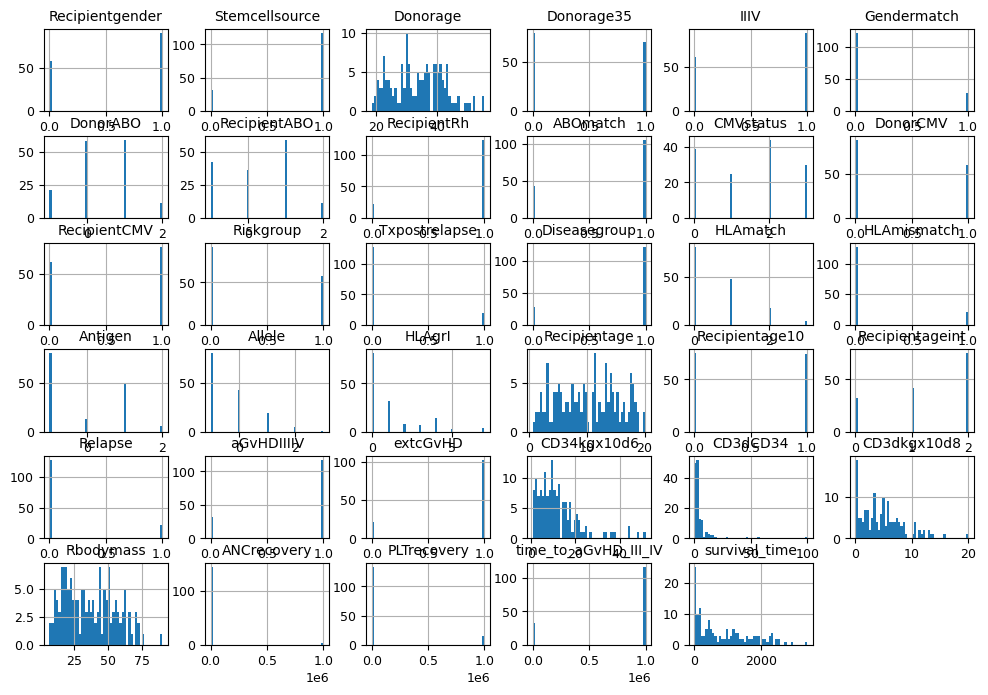

In [7]:
plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

X_train.hist(bins=50, figsize=(12, 8))
plt.show()

Let's perform some correlation analysis

<AxesSubplot: >

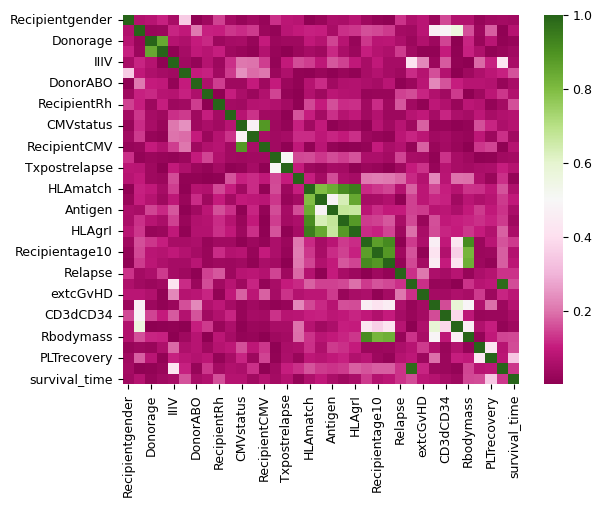

In [132]:
sns.heatmap(np.abs(X_train.drop(['Disease'], axis=1).corr()), cmap="PiYG")

In [8]:
num_features = ["Donorage", "CD34kgx10d6", "CD3dCD34", "CD3dkgx10d8", "Rbodymass", "ANCrecovery", "PLTrecovery", "time_to_aGvHD_III_IV", "survival_time"]

Let's correct all issues related to missing values

In [9]:
mode_features = ['RecipientABO', 'RecipientRh', 'ABOmatch', 'DonorCMV', 'Antigen', 'Allele']
median_features = ['CD3dCD34', 'CD3dkgx10d8', 'Rbodymass']
negative_one_features = ['extcGvHD']

X_train.isna().sum()

Recipientgender          0
Stemcellsource           0
Donorage                 0
Donorage35               0
IIIV                     0
Gendermatch              0
DonorABO                 0
RecipientABO             1
RecipientRh              2
ABOmatch                 1
CMVstatus               11
DonorCMV                 1
RecipientCMV            10
Disease                  0
Riskgroup                0
Txpostrelapse            0
Diseasegroup             0
HLAmatch                 0
HLAmismatch              0
Antigen                  1
Allele                   1
HLAgrI                   0
Recipientage             0
Recipientage10           0
Recipientageint          0
Relapse                  0
aGvHDIIIIV               0
extcGvHD                26
CD34kgx10d6              0
CD3dCD34                 5
CD3dkgx10d8              5
Rbodymass                2
ANCrecovery              0
PLTrecovery              0
time_to_aGvHD_III_IV     0
survival_time            0
dtype: int64

In [10]:
X_train = X_train.join(pd.get_dummies(X_train['CMVstatus'], prefix='CMVstatus').astype(int)).drop(['CMVstatus', 'RecipientCMV'], axis=1)
X_train.head()

,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,CMVstatus_0.0,CMVstatus_1.0,CMVstatus_2.0,CMVstatus_3.0
95,1,1,21.128767,0,1,1,0,0.0,1.0,0.0,...,7.16,54.1,15,17,1000000,1257,1,0,0,0
69,1,1,24.476712,0,1,0,0,1.0,1.0,1.0,...,4.78,49.0,14,17,1000000,1728,0,0,1,0
109,1,1,39.249315,1,1,0,0,1.0,1.0,1.0,...,6.35,24.3,13,12,1000000,28,0,0,1,0
29,0,1,39.172603,1,1,0,1,1.0,1.0,0.0,...,3.17,38.3,15,23,1000000,576,0,0,0,1
126,0,0,37.380822,1,1,0,1,0.0,1.0,1.0,...,10.14,51.3,14,15,1000000,2112,1,0,0,0


In [11]:
imputation_dict = {}

# Replace missing values with mode for specified features
for feature in mode_features:
    mode_value = X_train[feature].mode()[0]
    imputation_dict[feature] = mode_value
    X_train.fillna({feature: mode_value}, inplace=True)

# Replace missing values with median for specified features
for feature in median_features:
    median_value = X_train[feature].median()
    imputation_dict[feature] = median_value
    X_train.fillna({feature: median_value}, inplace=True)

# Replace missing values with -1 for specified features
for feature in negative_one_features:
    imputation_dict[feature] = -1
    X_train.fillna({feature: -1}, inplace=True)

X_train.isna().sum()

Recipientgender         0
Stemcellsource          0
Donorage                0
Donorage35              0
IIIV                    0
Gendermatch             0
DonorABO                0
RecipientABO            0
RecipientRh             0
ABOmatch                0
DonorCMV                0
Disease                 0
Riskgroup               0
Txpostrelapse           0
Diseasegroup            0
HLAmatch                0
HLAmismatch             0
Antigen                 0
Allele                  0
HLAgrI                  0
Recipientage            0
Recipientage10          0
Recipientageint         0
Relapse                 0
aGvHDIIIIV              0
extcGvHD                0
CD34kgx10d6             0
CD3dCD34                0
CD3dkgx10d8             0
Rbodymass               0
ANCrecovery             0
PLTrecovery             0
time_to_aGvHD_III_IV    0
survival_time           0
CMVstatus_0.0           0
CMVstatus_1.0           0
CMVstatus_2.0           0
CMVstatus_3.0           0
dtype: int64

Perform one-hot encoding for the appropriate columns

In [12]:
X_train = pd.get_dummies(X_train)

Compare data distribution of positive and negative classes

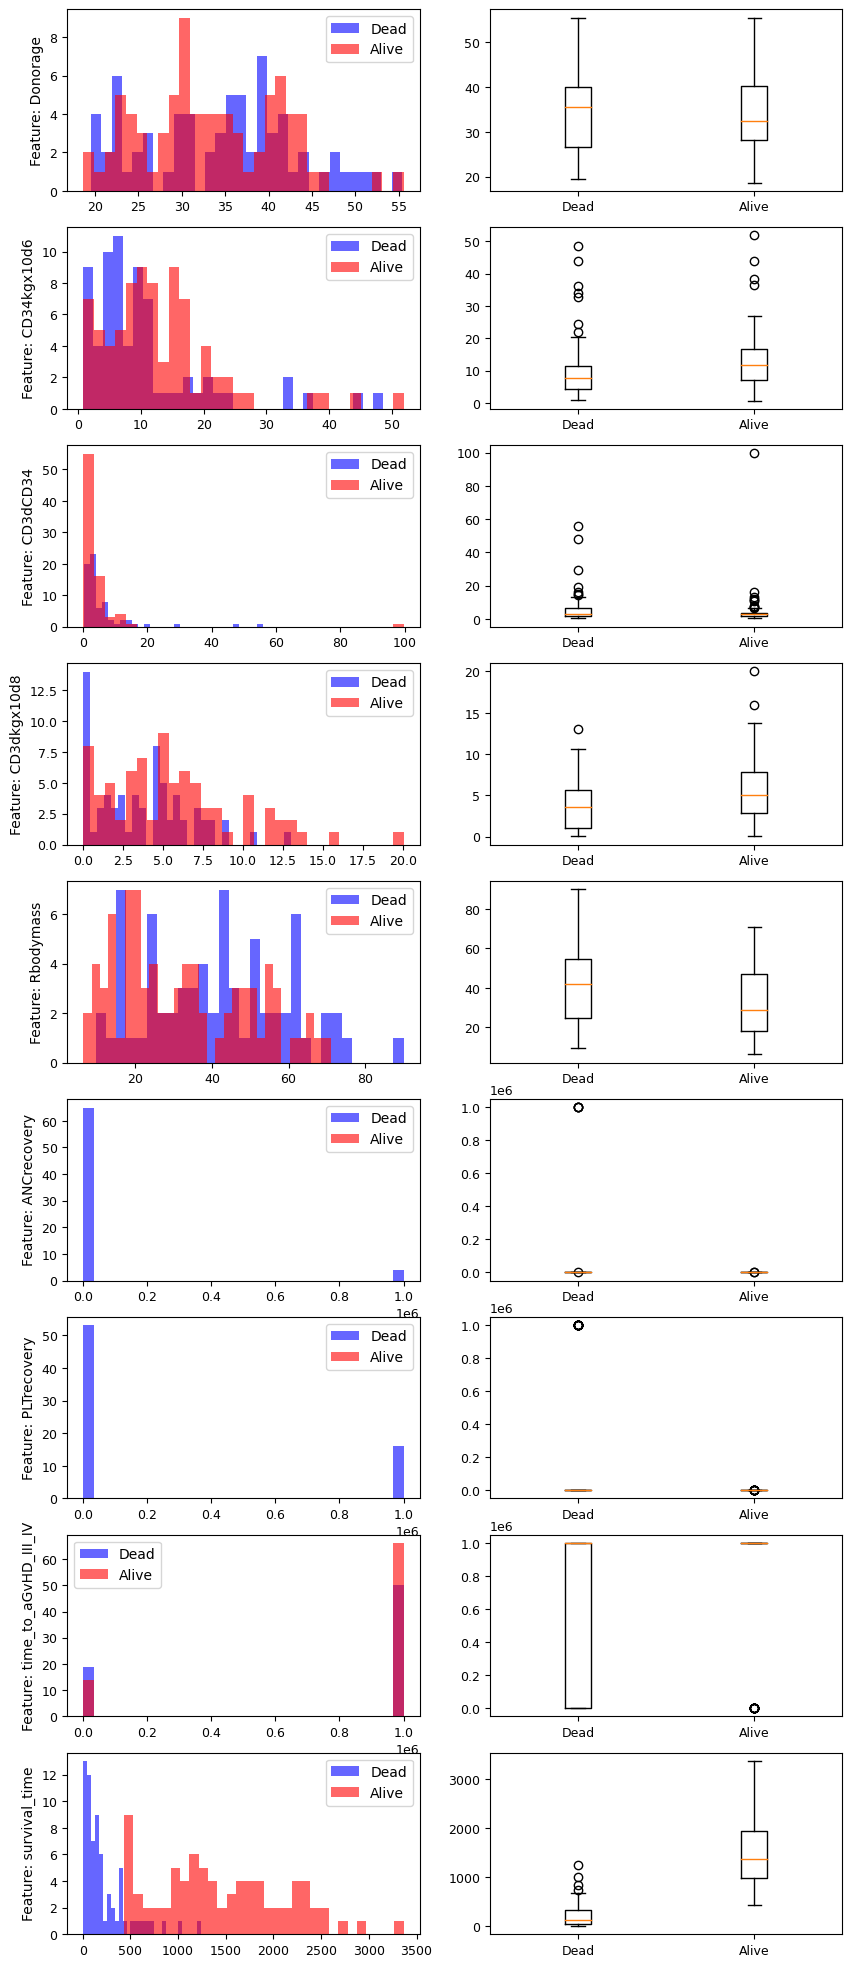

In [13]:
figure, axes = plt.subplots(len(num_features), 2, figsize=(10, 25))
for i, feature in enumerate(num_features):
    ax1, ax2 = axes[i, 0], axes[i, 1]
    ax1.set_ylabel(f"Feature: {feature}")

    dead = X_train[y_train["survival_status"] == 1][feature]
    alive = X_train[y_train["survival_status"] == 0][feature]

    ax1.hist(dead, label="Dead", alpha=0.6, color="blue", bins=30)
    ax1.hist(alive, label="Alive", alpha=0.6, color="red", bins=30)

    ax2.boxplot([dead, alive])
    ax2.set_xticklabels(["Dead", "Alive"])

    ax1.legend()

plt.show()

## Modeling with everything

Let's test modeling with all features

In [14]:
models = [
    (DecisionTreeClassifier, {}),
    (RandomForestClassifier, {}),
    (KNeighborsClassifier, {}),
    (SVC, {}),
    (MLPClassifier, {}),
    (GaussianNB, {})
]

In [15]:
def eval_model(X_train, y_train, features, model_=DecisionTreeClassifier, params={}):
    model = model_(**params)
    model.fit(X_train, y_train)
    cross_val = np.mean(cross_val_score(model, X_train, y_train, cv=10))
    cr = classification_report(y_train, model.predict(X_train), output_dict=True)
    return model, cross_val, cr

In [16]:
def eval_models(X_train, y_train, models):
    for model, params in models:
        model_, cv, cr = eval_model(X_train, y_train, X_train.columns, model, params)
        print(model, "\nCross Validation Score: ", cv)
        display(pd.DataFrame(cr))
        print("-" * 20)

In [17]:
eval_models(X_train, y_train, models)

<class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Cross Validation Score:  0.9057142857142859


,0,1,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,80.0,69.0,1.0,149.0,149.0


--------------------
<class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Cross Validation Score:  0.9328571428571429


,0,1,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,80.0,69.0,1.0,149.0,149.0


--------------------
<class 'sklearn.neighbors._classification.KNeighborsClassifier'> 
Cross Validation Score:  0.9061904761904762


,0,1,accuracy,macro avg,weighted avg
precision,0.928571,0.969231,0.946309,0.948901,0.947400
recall,0.975000,0.913043,0.946309,0.944022,0.946309
f1-score,0.951220,0.940299,0.946309,0.945759,0.946162
support,80.000000,69.000000,0.946309,149.000000,149.000000


--------------------
<class 'sklearn.svm._classes.SVC'> 
Cross Validation Score:  0.5971428571428572


,0,1,accuracy,macro avg,weighted avg
precision,0.628571,0.681818,0.644295,0.655195,0.653229
recall,0.825000,0.434783,0.644295,0.629891,0.644295
f1-score,0.713514,0.530973,0.644295,0.622243,0.628982
support,80.000000,69.000000,0.644295,149.000000,149.000000


--------------------
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'> 
Cross Validation Score:  0.6304761904761904


,0,1,accuracy,macro avg,weighted avg
precision,0.933333,0.507463,0.550336,0.720398,0.736118
recall,0.175000,0.985507,0.550336,0.580254,0.550336
f1-score,0.294737,0.669951,0.550336,0.482344,0.468494
support,80.000000,69.000000,0.550336,149.000000,149.000000


--------------------
<class 'sklearn.naive_bayes.GaussianNB'> 
Cross Validation Score:  0.6376190476190475


,0,1,accuracy,macro avg,weighted avg
precision,0.601504,1.000000,0.644295,0.800752,0.786042
recall,1.000000,0.231884,0.644295,0.615942,0.644295
f1-score,0.751174,0.376471,0.644295,0.563822,0.577653
support,80.000000,69.000000,0.644295,149.000000,149.000000


--------------------


The performance of the different models seem to vary significantly, with Random Forest being potentially the best model so far.

These results also show that multiple models are suffering from overfitting. 

## Feature Engineering + Modeling

Let's try to perform feature engineering and feature selection

Create feature to check ABO compatibility

In [18]:
def check_compatibility(donor_abo, recipient_abo):
    blood_type_map = {
        0: "O",
        1: "A",
        -1: "B",
        2: "AB"
    }

    compatibility = {
        "O": ["O", "A", "B", "AB"],
        "A": ["A", "AB"],
        "B": ["B", "AB"],
        "AB": ["AB"]
    }

    donor_blood_type = blood_type_map.get(donor_abo)
    recipient_blood_type = blood_type_map.get(recipient_abo)

    if donor_blood_type is None or recipient_blood_type is None:
        return 4

    return recipient_blood_type in compatibility[donor_blood_type]

X_train['compatibilityABO'] = X_train.apply(lambda row: check_compatibility(row['DonorABO'], row['RecipientABO']), axis=1)

Let's try to perform forward selection iteratively with decision trees to get the best possible feature set

In [19]:
def find_best(X_train, y_train, candidate_feature_sets, model = DecisionTreeClassifier, params = {}):
    candidate_accuracies = []

    for candidate_features in candidate_feature_sets:
        _, cross_val, _ = eval_model(X_train, y_train, candidate_features, model_=model, params=params)
        candidate_accuracies.append((candidate_features, cross_val))

    return max(candidate_accuracies, key=lambda x: x[1])

In [20]:
clf = DecisionTreeClassifier(random_state=42)
best_features = []

for i in range(1, 11):
    sfs = SequentialFeatureSelector(estimator=clf, n_features_to_select=i)
    sfs.fit(X_train, y_train)
    best_features.append(sfs.feature_names_in_[sfs.get_support()])

In [21]:
best_feature_set = find_best(X_train, y_train, best_features)
best_feature_set = best_feature_set[0].tolist()

In [22]:
print(best_feature_set)

['Donorage35', 'Txpostrelapse', 'Recipientage10', 'Relapse', 'survival_time', 'Disease_lymphoma']


Let's compare these results with the feature importances of RandomForest

In [23]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
rf_classifier

RandomForestClassifier(random_state=42)

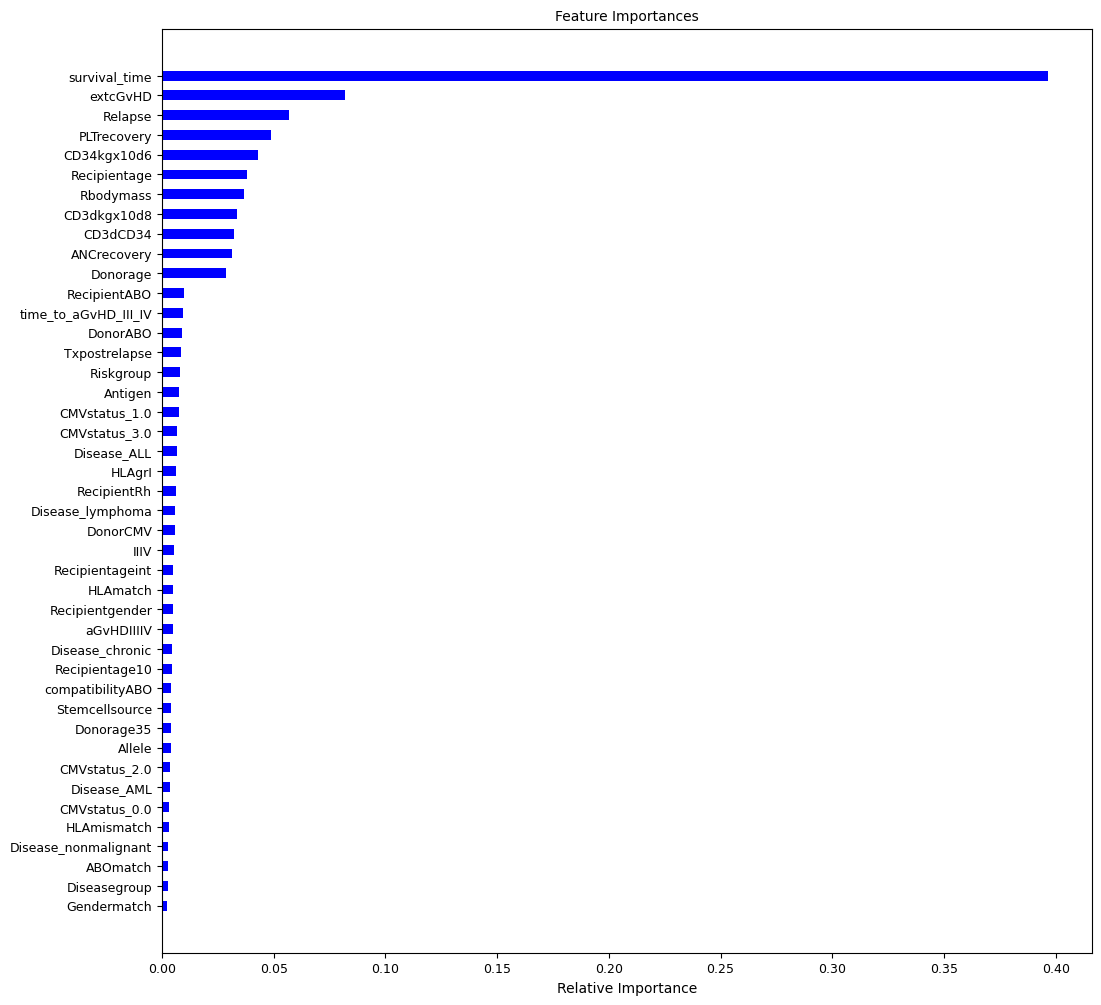

In [24]:
features = X_train.columns
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center', height=0.5)
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

The results seem to be quite similar. Let's proceed with the selected best features

In [25]:
eval_models(X_train[best_feature_set], y_train, models)

<class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Cross Validation Score:  0.9533333333333334


,0,1,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,80.0,69.0,1.0,149.0,149.0


--------------------
<class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Cross Validation Score:  0.9328571428571429


,0,1,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0
recall,1.0,1.0,1.0,1.0,1.0
f1-score,1.0,1.0,1.0,1.0,1.0
support,80.0,69.0,1.0,149.0,149.0


--------------------
<class 'sklearn.neighbors._classification.KNeighborsClassifier'> 
Cross Validation Score:  0.9261904761904762


,0,1,accuracy,macro avg,weighted avg
precision,0.927711,0.954545,0.939597,0.941128,0.940138
recall,0.962500,0.913043,0.939597,0.937772,0.939597
f1-score,0.944785,0.933333,0.939597,0.939059,0.939482
support,80.000000,69.000000,0.939597,149.000000,149.000000


--------------------
<class 'sklearn.svm._classes.SVC'> 
Cross Validation Score:  0.8657142857142857


,0,1,accuracy,macro avg,weighted avg
precision,0.906667,0.837838,0.872483,0.872252,0.874793
recall,0.850000,0.898551,0.872483,0.874275,0.872483
f1-score,0.877419,0.867133,0.872483,0.872276,0.872656
support,80.000000,69.000000,0.872483,149.000000,149.000000


--------------------
<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'> 
Cross Validation Score:  0.5652380952380953


/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,0,1,accuracy,macro avg,weighted avg
precision,0.540541,1.000000,0.543624,0.770270,0.753310
recall,1.000000,0.014493,0.543624,0.507246,0.543624
f1-score,0.701754,0.028571,0.543624,0.365163,0.390012
support,80.000000,69.000000,0.543624,149.000000,149.000000


--------------------
<class 'sklearn.naive_bayes.GaussianNB'> 
Cross Validation Score:  0.710952380952381


,0,1,accuracy,macro avg,weighted avg
precision,0.655462,0.933333,0.711409,0.794398,0.784141
recall,0.975000,0.405797,0.711409,0.690399,0.711409
f1-score,0.783920,0.565657,0.711409,0.674788,0.682845
support,80.000000,69.000000,0.711409,149.000000,149.000000


--------------------


The results now improved after performing feature engineering and selection!

There is a catch however, we suspect survival time to contain data leakage...

## Handling Data Leakage

In [26]:
leaking_features = ["survival_time"]
best_feature_set.remove(*leaking_features)
best_feature_set

['Donorage35',
 'Txpostrelapse',
 'Recipientage10',
 'Relapse',
 'Disease_lymphoma']

In [27]:
X_train_new = X_train.drop(leaking_features, axis=1)
X_train_new.head()

,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,CMVstatus_0.0,CMVstatus_1.0,CMVstatus_2.0,CMVstatus_3.0,Disease_ALL,Disease_AML,Disease_chronic,Disease_lymphoma,Disease_nonmalignant,compatibilityABO
95,1,1,21.128767,0,1,1,0,0.0,1.0,0.0,...,1,0,0,0,True,False,False,False,False,True
69,1,1,24.476712,0,1,0,0,1.0,1.0,1.0,...,0,0,1,0,False,True,False,False,False,True
109,1,1,39.249315,1,1,0,0,1.0,1.0,1.0,...,0,0,1,0,False,False,False,False,True,True
29,0,1,39.172603,1,1,0,1,1.0,1.0,0.0,...,0,0,0,1,True,False,False,False,False,True
126,0,0,37.380822,1,1,0,1,0.0,1.0,1.0,...,1,0,0,0,False,True,False,False,False,False


In [28]:
clf = DecisionTreeClassifier()
best_features_new = []

for i in range(1, 11):
    sfs = SequentialFeatureSelector(estimator=clf, n_features_to_select=i)
    sfs.fit(X_train_new, y_train)
    best_features_new.append(sfs.feature_names_in_[sfs.get_support()])

In [29]:
best_feature_set_new = find_best(X_train, y_train, best_features_new)
best_feature_set_new = best_feature_set_new[0].tolist()
print(best_feature_set_new)

['Gendermatch', 'ABOmatch', 'DonorCMV', 'HLAmismatch', 'Relapse', 'extcGvHD', 'Disease_chronic']


In [30]:
eval_models(X_train_new[best_feature_set_new], y_train, models)

<class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Cross Validation Score:  0.8657142857142857


,0,1,accuracy,macro avg,weighted avg
precision,0.877778,0.983051,0.919463,0.930414,0.926528
recall,0.987500,0.840580,0.919463,0.914040,0.919463
f1-score,0.929412,0.906250,0.919463,0.917831,0.918686
support,80.000000,69.000000,0.919463,149.000000,149.000000


--------------------
<class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Cross Validation Score:  0.8523809523809524


,0,1,accuracy,macro avg,weighted avg
precision,0.886364,0.967213,0.919463,0.926788,0.923804
recall,0.975000,0.855072,0.919463,0.915036,0.919463
f1-score,0.928571,0.907692,0.919463,0.918132,0.918903
support,80.000000,69.000000,0.919463,149.000000,149.000000


--------------------
<class 'sklearn.neighbors._classification.KNeighborsClassifier'> 
Cross Validation Score:  0.8452380952380952


,0,1,accuracy,macro avg,weighted avg
precision,0.813187,0.896552,0.845638,0.854869,0.851792
recall,0.925000,0.753623,0.845638,0.839312,0.845638
f1-score,0.865497,0.818898,0.845638,0.842197,0.843917
support,80.000000,69.000000,0.845638,149.000000,149.000000


--------------------
<class 'sklearn.svm._classes.SVC'> 
Cross Validation Score:  0.8385714285714286


,0,1,accuracy,macro avg,weighted avg
precision,0.852273,0.918033,0.879195,0.885153,0.882725
recall,0.937500,0.811594,0.879195,0.874547,0.879195
f1-score,0.892857,0.861538,0.879195,0.877198,0.878354
support,80.000000,69.000000,0.879195,149.000000,149.000000


--------------------


/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ellzo/.local/lib/python3.11/site-packages/skle

<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'> 
Cross Validation Score:  0.8385714285714286


/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,0,1,accuracy,macro avg,weighted avg
precision,0.852273,0.918033,0.879195,0.885153,0.882725
recall,0.937500,0.811594,0.879195,0.874547,0.879195
f1-score,0.892857,0.861538,0.879195,0.877198,0.878354
support,80.000000,69.000000,0.879195,149.000000,149.000000


--------------------
<class 'sklearn.naive_bayes.GaussianNB'> 
Cross Validation Score:  0.8252380952380951


,0,1,accuracy,macro avg,weighted avg
precision,0.829268,0.820896,0.825503,0.825082,0.825391
recall,0.850000,0.797101,0.825503,0.823551,0.825503
f1-score,0.839506,0.808824,0.825503,0.824165,0.825297
support,80.000000,69.000000,0.825503,149.000000,149.000000


--------------------


The results may not be as good as they used to be after removing survival_time. However, this is important to ensure objective results and a modeling that could be used during inference time.

## Removing Post-Transplantation Features

Let's perform the modeling without post-transplantation features since they cannot be obtained until the transplantation is done

In [31]:
X_train.columns

Index(['Recipientgender', 'Stemcellsource', 'Donorage', 'Donorage35', 'IIIV',
       'Gendermatch', 'DonorABO', 'RecipientABO', 'RecipientRh', 'ABOmatch',
       'DonorCMV', 'Riskgroup', 'Txpostrelapse', 'Diseasegroup', 'HLAmatch',
       'HLAmismatch', 'Antigen', 'Allele', 'HLAgrI', 'Recipientage',
       'Recipientage10', 'Recipientageint', 'Relapse', 'aGvHDIIIIV',
       'extcGvHD', 'CD34kgx10d6', 'CD3dCD34', 'CD3dkgx10d8', 'Rbodymass',
       'ANCrecovery', 'PLTrecovery', 'time_to_aGvHD_III_IV', 'survival_time',
       'CMVstatus_0.0', 'CMVstatus_1.0', 'CMVstatus_2.0', 'CMVstatus_3.0',
       'Disease_ALL', 'Disease_AML', 'Disease_chronic', 'Disease_lymphoma',
       'Disease_nonmalignant', 'compatibilityABO'],
      dtype='object')

In [32]:
post_features = ["survival_time", "Relapse", "time_to_aGvHD_III_IV", "PLTrecovery", "ANCrecovery", "extcGvHD", "aGvHDIIIIV"]

X_train_post = X_train.drop(post_features, axis=1)
X_train_post.head()

,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,...,CMVstatus_0.0,CMVstatus_1.0,CMVstatus_2.0,CMVstatus_3.0,Disease_ALL,Disease_AML,Disease_chronic,Disease_lymphoma,Disease_nonmalignant,compatibilityABO
95,1,1,21.128767,0,1,1,0,0.0,1.0,0.0,...,1,0,0,0,True,False,False,False,False,True
69,1,1,24.476712,0,1,0,0,1.0,1.0,1.0,...,0,0,1,0,False,True,False,False,False,True
109,1,1,39.249315,1,1,0,0,1.0,1.0,1.0,...,0,0,1,0,False,False,False,False,True,True
29,0,1,39.172603,1,1,0,1,1.0,1.0,0.0,...,0,0,0,1,True,False,False,False,False,True
126,0,0,37.380822,1,1,0,1,0.0,1.0,1.0,...,1,0,0,0,False,True,False,False,False,False


In [33]:
clf = DecisionTreeClassifier()
best_features_post = []

for i in range(1, 11):
    sfs = SequentialFeatureSelector(estimator=clf, n_features_to_select=i)
    sfs.fit(X_train_post, y_train)
    best_features_post.append(sfs.feature_names_in_[sfs.get_support()])

In [34]:
best_feature_set_post = find_best(X_train, y_train, best_features_post)
best_feature_set_post = best_feature_set_post[0].tolist()
print(best_feature_set_post)

['Stemcellsource', 'RecipientRh', 'Txpostrelapse', 'Diseasegroup', 'HLAmismatch', 'CMVstatus_3.0', 'Disease_chronic', 'Disease_lymphoma', 'Disease_nonmalignant']


In [35]:
eval_models(X_train_post[best_feature_set_post], y_train, models)

<class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Cross Validation Score:  0.6704761904761904


,0,1,accuracy,macro avg,weighted avg
precision,0.707547,0.883721,0.758389,0.795634,0.789131
recall,0.937500,0.550725,0.758389,0.744112,0.758389
f1-score,0.806452,0.678571,0.758389,0.742512,0.747232
support,80.000000,69.000000,0.758389,149.000000,149.000000


--------------------
<class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Cross Validation Score:  0.6576190476190475


,0,1,accuracy,macro avg,weighted avg
precision,0.715686,0.851064,0.758389,0.783375,0.778378
recall,0.912500,0.579710,0.758389,0.746105,0.758389
f1-score,0.802198,0.689655,0.758389,0.745926,0.750081
support,80.000000,69.000000,0.758389,149.000000,149.000000


--------------------
<class 'sklearn.neighbors._classification.KNeighborsClassifier'> 
Cross Validation Score:  0.6709523809523811


,0,1,accuracy,macro avg,weighted avg
precision,0.679245,0.813953,0.718121,0.746599,0.741627
recall,0.900000,0.507246,0.718121,0.703623,0.718121
f1-score,0.774194,0.625000,0.718121,0.699597,0.705104
support,80.000000,69.000000,0.718121,149.000000,149.000000


--------------------
<class 'sklearn.svm._classes.SVC'> 
Cross Validation Score:  0.6642857142857144


,0,1,accuracy,macro avg,weighted avg
precision,0.686275,0.787234,0.718121,0.736754,0.733028
recall,0.875000,0.536232,0.718121,0.705616,0.718121
f1-score,0.769231,0.637931,0.718121,0.703581,0.708428
support,80.000000,69.000000,0.718121,149.000000,149.000000


--------------------


/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ellzo/.local/lib/python3.11/site-packages/skle

<class 'sklearn.neural_network._multilayer_perceptron.MLPClassifier'> 
Cross Validation Score:  0.6514285714285715


/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


,0,1,accuracy,macro avg,weighted avg
precision,0.710000,0.816327,0.744966,0.763163,0.759238
recall,0.887500,0.579710,0.744966,0.733605,0.744966
f1-score,0.788889,0.677966,0.744966,0.733427,0.737522
support,80.000000,69.000000,0.744966,149.000000,149.000000


--------------------
<class 'sklearn.naive_bayes.GaussianNB'> 
Cross Validation Score:  0.5771428571428571


,0,1,accuracy,macro avg,weighted avg
precision,0.563380,1.000000,0.583893,0.781690,0.765573
recall,1.000000,0.101449,0.583893,0.550725,0.583893
f1-score,0.720721,0.184211,0.583893,0.452466,0.472270
support,80.000000,69.000000,0.583893,149.000000,149.000000


--------------------


## Hyperparameter Optimization for Post-Tranplantation

We will first perform hyperparameter optimization for all selected features, then for features that could be obtained prior to transplantation

### 1- Decision Tree

We will first start with RandomizedSearchCV to optimize over a large search space.

In [36]:
random_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": list(range(1, 10)) + [None],
    "min_samples_split": range(2, 15),
    "min_samples_leaf": range(1, 10)
}

In [37]:
rs = RandomizedSearchCV(DecisionTreeClassifier(), random_params, cv=10)
rs.fit(X_train_new[best_feature_set_new], y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      None],
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(2, 15)})

In [38]:
print(rs.best_params_)
print(rs.best_score_)

{'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 9, 'criterion': 'entropy'}
0.8590476190476191


After getting an idea of the best range of the different hyperparameters. Let's perform a more focused optimization on a smaller search space using GridSearchCV by testing all its combinations. 

In [57]:
params = {
    "criterion": ["gini", "entropy"],
    "max_depth": range(6, 10),
    "min_samples_split": range(4, 8),
    "min_samples_leaf": range(2, 8)
}

In [58]:
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=10, n_jobs=8)
grid_dt.fit(X_train_new[best_feature_set_new], y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=8,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(6, 10),
                         'min_samples_leaf': range(2, 8),
                         'min_samples_split': range(4, 8)})

In [59]:
print(grid_dt.best_estimator_)
print(grid_dt.best_params_)
print(grid_dt.best_score_)

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=2,
                       min_samples_split=7)
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 7}
0.8523809523809524


In [60]:
pd.DataFrame(classification_report(y_train, grid_dt.best_estimator_.predict(X_train_new[best_feature_set_new]), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.847826,0.964912,0.892617,0.906369,0.902047
recall,0.975000,0.797101,0.892617,0.886051,0.892617
f1-score,0.906977,0.873016,0.892617,0.889996,0.891250
support,80.000000,69.000000,0.892617,149.000000,149.000000


### 2- Random Forest

Random Forest performed pretty well earlier. Let's see how good it will perform after optimizing its hyperparameters

In [45]:
random_params = {
    "n_estimators": range(2, 500),
    "criterion": ["gini", "entropy"],
    "max_depth": list(range(1, 10)) + [None],
    "min_samples_split": range(2, 15),
    "min_samples_leaf": range(1, 10)
}

In [46]:
rs = RandomizedSearchCV(RandomForestClassifier(), random_params, cv=10, n_iter=30)
rs.fit(X_train_new[best_feature_set_new], y_train)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=30,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      None],
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(2, 15),
                                        'n_estimators': range(2, 500)})

In [47]:
print(rs.best_params_)
print(rs.best_score_)

{'n_estimators': 62, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_depth': 5, 'criterion': 'entropy'}
0.871904761904762


After getting an idea of the best range of the different hyperparameters. Let's perform a more focused optimization on a smaller search space using GridSearchCV by testing all its combinations. 

In [69]:
params = {
    "n_estimators": [60, 65, 62, 70, 75],
    "criterion": ["gini", "entropy"],
    "max_depth": [5],
    "min_samples_split": [12, 14, 15],
    "min_samples_leaf": [2, 3, 5, 7]
}

In [70]:
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=10, n_jobs=8)
grid_rf.fit(X_train_new[best_feature_set_new], y_train)

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=8,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5],
                         'min_samples_leaf': [2, 3, 5, 7],
                         'min_samples_split': [12, 14, 15],
                         'n_estimators': [60, 65, 62, 70, 75]})

In [71]:
print(grid_rf.best_estimator_)
print(grid_rf.best_params_)
print(grid_rf.best_score_)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=65)
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 65}
0.8652380952380951


In [72]:
pd.DataFrame(classification_report(y_train, grid_rf.best_estimator_.predict(X_train_new[best_feature_set_new]), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.839080,0.887097,0.85906,0.863089,0.861316
recall,0.912500,0.797101,0.85906,0.854801,0.859060
f1-score,0.874251,0.839695,0.85906,0.856973,0.858249
support,80.000000,69.000000,0.85906,149.000000,149.000000


### 3- K-Nearest Neighbors

Next, let's do the same for KNNs

In [52]:
random_params = {
    "n_neighbors": range(2, 100),
    "weights": ["uniform", "distance"],
    "p": range(1, 5),
}

In [53]:
rs = RandomizedSearchCV(KNeighborsClassifier(), random_params, cv=10, n_iter=50)
rs.fit(X_train_new[best_feature_set_new], y_train)

RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(), n_iter=50,
                   param_distributions={'n_neighbors': range(2, 100),
                                        'p': range(1, 5),
                                        'weights': ['uniform', 'distance']})

In [54]:
print(rs.best_params_)
print(rs.best_score_)

{'weights': 'distance', 'p': 1, 'n_neighbors': 17}
0.8728571428571428


In [73]:
params = {
    "n_neighbors": [12, 15, 17, 20, 25],
    "weights": ["uniform", "distance"],
    "p": [1, 2],
}

In [74]:
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=10, n_jobs=8)
grid_knn.fit(X_train_new[best_feature_set_new], y_train)

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=8,
             param_grid={'n_neighbors': [12, 15, 17, 20, 25], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [75]:
print(grid_knn.best_estimator_)
print(grid_knn.best_params_)
print(grid_knn.best_score_)

KNeighborsClassifier(n_neighbors=15, p=1, weights='distance')
{'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
0.8728571428571428


In [76]:
pd.DataFrame(classification_report(y_train, grid_knn.best_estimator_.predict(X_train_new[best_feature_set_new]), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.877778,0.983051,0.919463,0.930414,0.926528
recall,0.987500,0.840580,0.919463,0.914040,0.919463
f1-score,0.929412,0.906250,0.919463,0.917831,0.918686
support,80.000000,69.000000,0.919463,149.000000,149.000000


### 4- Support Vector Machines

Finally, let's perform hyperparameter optimization for SVMs

In [78]:
random_params = {
    "C": np.arange(0.001, 20, 0.5),
    "kernel": ["linear", "poly", "rbf"],
    "degree": range(1, 5),
    "gamma": ["scale", "auto"]
}

In [82]:
rs = RandomizedSearchCV(SVC(), random_params, cv=10, n_iter=30)
rs.fit(X_train_new[best_feature_set_new], y_train)

RandomizedSearchCV(cv=10, estimator=SVC(), n_iter=30,
                   param_distributions={'C': array([1.0000e-03, 5.0100e-01, 1.0010e+00, 1.5010e+00, 2.0010e+00,
       2.5010e+00, 3.0010e+00, 3.5010e+00, 4.0010e+00, 4.5010e+00,
       5.0010e+00, 5.5010e+00, 6.0010e+00, 6.5010e+00, 7.0010e+00,
       7.5010e+00, 8.0010e+00, 8.5010e+00, 9.0010e+00, 9.5010e+00,
       1.0001e+01, 1.0501e+01, 1.1001e+01, 1.1501e+01, 1.2001e+01,
       1.2501e+01, 1.3001e+01, 1.3501e+01, 1.4001e+01, 1.4501e+01,
       1.5001e+01, 1.5501e+01, 1.6001e+01, 1.6501e+01, 1.7001e+01,
       1.7501e+01, 1.8001e+01, 1.8501e+01, 1.9001e+01, 1.9501e+01]),
                                        'degree': range(1, 5),
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']})

In [83]:
print(rs.best_params_)
print(rs.best_score_)

{'kernel': 'poly', 'gamma': 'scale', 'degree': 3, 'C': 17.001}
0.8523809523809524


In [84]:
params = {
    "C": [15, 17, 20],
    "kernel": ["linear", "poly", "rbf"],
    "degree": [3],
    "gamma": ["scale", "auto"]
}

In [85]:
grid_svm = GridSearchCV(SVC(), param_grid=params, cv=10, n_jobs=8)
grid_svm.fit(X_train_new[best_feature_set_new], y_train)

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

GridSearchCV(cv=10, estimator=SVC(), n_jobs=8,
             param_grid={'C': [15, 17, 20], 'degree': [3],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']})

In [86]:
print(grid_svm.best_estimator_)
print(grid_svm.best_params_)
print(grid_svm.best_score_)

SVC(C=15, kernel='poly')
{'C': 15, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
0.8523809523809524


In [87]:
pd.DataFrame(classification_report(y_train, grid_svm.best_estimator_.predict(X_train_new[best_feature_set_new]), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.886364,0.967213,0.919463,0.926788,0.923804
recall,0.975000,0.855072,0.919463,0.915036,0.919463
f1-score,0.928571,0.907692,0.919463,0.918132,0.918903
support,80.000000,69.000000,0.919463,149.000000,149.000000


## Hyperparameter Tuning for Pre-Transplantation

### 1- Decision Tree

In [98]:
params = {
    "criterion": ["gini", "entropy"],
    "max_depth": range(6, 10),
    "min_samples_split": range(4, 8),
    "min_samples_leaf": range(2, 8)
}

In [99]:
grid_dt_pre = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=10, n_jobs=8)
grid_dt_pre.fit(X_train_post[best_feature_set_post], y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=8,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(6, 10),
                         'min_samples_leaf': range(2, 8),
                         'min_samples_split': range(4, 8)})

In [100]:
print(grid_dt_pre.best_estimator_)
print(grid_dt_pre.best_params_)
print(grid_dt_pre.best_score_)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=6, min_samples_split=4)
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 4}
0.6704761904761904


In [101]:
pd.DataFrame(classification_report(y_train, grid_dt_pre.best_estimator_.predict(X_train_post[best_feature_set_post]), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.673469,0.725490,0.691275,0.699480,0.697560
recall,0.825000,0.536232,0.691275,0.680616,0.691275
f1-score,0.741573,0.616667,0.691275,0.679120,0.683730
support,80.000000,69.000000,0.691275,149.000000,149.000000


### 2- Random Forest

In [104]:
params = {
    "n_estimators": [50, 60, 65, 70, 100],
    "criterion": ["gini", "entropy"],
    "max_depth": [5],
    "min_samples_split": [12, 15],
    "min_samples_leaf": [2, 5, 7]
}

In [105]:
grid_rf_pre = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=10, n_jobs=8)
grid_rf_pre.fit(X_train_post[best_feature_set_post], y_train)

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=8,
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [5],
                         'min_samples_leaf': [2, 5, 7],
                         'min_samples_split': [12, 15],
                         'n_estimators': [50, 60, 65, 70, 100]})

In [106]:
print(grid_rf_pre.best_estimator_)
print(grid_rf_pre.best_params_)
print(grid_rf_pre.best_score_)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=12,
                       n_estimators=65)
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 65}
0.6847619047619048


In [107]:
pd.DataFrame(classification_report(y_train, grid_rf_pre.best_estimator_.predict(X_train_post[best_feature_set_post]), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.692308,0.822222,0.731544,0.757265,0.752469
recall,0.900000,0.536232,0.731544,0.718116,0.731544
f1-score,0.782609,0.649123,0.731544,0.715866,0.720793
support,80.000000,69.000000,0.731544,149.000000,149.000000


### 3- K-Nearest Neighbors

In [108]:
params = {
    "n_neighbors": [12, 15, 20, 25],
    "weights": ["uniform", "distance"],
    "p": [1, 2],
}

In [109]:
grid_knn_pre = GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=10, n_jobs=8)
grid_knn_pre.fit(X_train_post[best_feature_set_post], y_train)

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=8,
             param_grid={'n_neighbors': [12, 15, 20, 25], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [110]:
print(grid_knn_pre.best_estimator_)
print(grid_knn_pre.best_params_)
print(grid_knn_pre.best_score_)

KNeighborsClassifier(n_neighbors=15, weights='distance')
{'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
0.670952380952381


In [111]:
pd.DataFrame(classification_report(y_train, grid_knn_pre.best_estimator_.predict(X_train_post[best_feature_set_post]), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.707547,0.883721,0.758389,0.795634,0.789131
recall,0.937500,0.550725,0.758389,0.744112,0.758389
f1-score,0.806452,0.678571,0.758389,0.742512,0.747232
support,80.000000,69.000000,0.758389,149.000000,149.000000


### 4- Support Vector Machines

In [112]:
params = {
    "C": [15, 17, 20],
    "kernel": ["linear", "poly", "rbf"],
    "degree": [3],
    "gamma": ["scale", "auto"]
}

In [113]:
grid_svm_pre = GridSearchCV(SVC(), param_grid=params, cv=10, n_jobs=8)
grid_svm_pre.fit(X_train_post[best_feature_set_post], y_train)

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ellzo/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

GridSearchCV(cv=10, estimator=SVC(), n_jobs=8,
             param_grid={'C': [15, 17, 20], 'degree': [3],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']})

In [114]:
print(grid_svm_pre.best_estimator_)
print(grid_svm_pre.best_params_)
print(grid_svm_pre.best_score_)

SVC(C=15, kernel='poly')
{'C': 15, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
0.6776190476190476


In [115]:
pd.DataFrame(classification_report(y_train, grid_svm_pre.best_estimator_.predict(X_train_post[best_feature_set_post]), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.711538,0.866667,0.758389,0.789103,0.783376
recall,0.925000,0.565217,0.758389,0.745109,0.758389
f1-score,0.804348,0.684211,0.758389,0.744279,0.748714
support,80.000000,69.000000,0.758389,149.000000,149.000000


Whoo! It's been a long journey so far. We have now a model that could be used for inference. Let's proceed to the final evaluation using the test set we kept aside all this time.

## Final Evaluation

We start by performing the exact same preprocessing as we did on the train set

In [119]:
X_test.fillna(imputation_dict, inplace=True)

In [120]:
X_test = X_test.join(pd.get_dummies(X_test['CMVstatus'], prefix='CMVstatus').astype(int)).drop(['CMVstatus', 'RecipientCMV'], axis=1)

In [121]:
X_test = pd.get_dummies(X_test)

### Modeling for Post-Transplantation

In [117]:
X_test_new = X_test.drop(leaking_features, axis=1)

بسم الله

In [92]:
pd.DataFrame(classification_report(y_test, grid_dt.best_estimator_.predict(X_test_new[best_feature_set_new]), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.760000,0.769231,0.763158,0.764615,0.763887
recall,0.863636,0.625000,0.763158,0.744318,0.763158
f1-score,0.808511,0.689655,0.763158,0.749083,0.758466
support,22.000000,16.000000,0.763158,38.000000,38.000000


In [93]:
pd.DataFrame(classification_report(y_test, grid_rf.best_estimator_.predict(X_test_new[best_feature_set_new]), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.791667,0.785714,0.789474,0.788690,0.789160
recall,0.863636,0.687500,0.789474,0.775568,0.789474
f1-score,0.826087,0.733333,0.789474,0.779710,0.787033
support,22.000000,16.000000,0.789474,38.000000,38.000000


In [94]:
pd.DataFrame(classification_report(y_test, grid_knn.best_estimator_.predict(X_test_new[best_feature_set_new]), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.750000,0.900000,0.789474,0.825000,0.813158
recall,0.954545,0.562500,0.789474,0.758523,0.789474
f1-score,0.840000,0.692308,0.789474,0.766154,0.777814
support,22.000000,16.000000,0.789474,38.000000,38.000000


In [95]:
pd.DataFrame(classification_report(y_test, grid_svm.best_estimator_.predict(X_test_new[best_feature_set_new]), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.769231,0.833333,0.789474,0.801282,0.796221
recall,0.909091,0.625000,0.789474,0.767045,0.789474
f1-score,0.833333,0.714286,0.789474,0.773810,0.783208
support,22.000000,16.000000,0.789474,38.000000,38.000000


In [96]:
dt_frp, dt_tpr, dt_thresh = roc_curve(y_test, grid_dt.best_estimator_.predict(X_test_new[best_feature_set_new]))
rf_frp, rf_tpr, rf_thresh = roc_curve(y_test, grid_rf.best_estimator_.predict(X_test_new[best_feature_set_new]))
knn_frp, knn_tpr, knn_thresh = roc_curve(y_test, grid_knn.best_estimator_.predict(X_test_new[best_feature_set_new]))
svm_frp, svm_tpr, svm_thresh = roc_curve(y_test, grid_svm.best_estimator_.predict(X_test_new[best_feature_set_new]))


dt_auc = roc_auc_score(y_test, grid_dt.best_estimator_.predict(X_test_new[best_feature_set_new]))
rf_auc = roc_auc_score(y_test, grid_rf.best_estimator_.predict(X_test_new[best_feature_set_new]))
knn_auc = roc_auc_score(y_test, grid_knn.best_estimator_.predict(X_test_new[best_feature_set_new]))
svm_auc = roc_auc_score(y_test, grid_svm.best_estimator_.predict(X_test_new[best_feature_set_new]))

Text(0.5, 1.0, 'ROC')

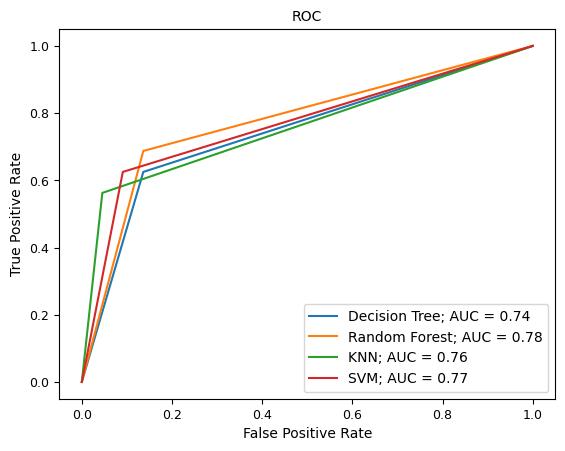

In [97]:
plt.plot(dt_frp, dt_tpr, label=f"Decision Tree; AUC = {dt_auc:.2f}")
plt.plot(rf_frp, rf_tpr, label=f"Random Forest; AUC = {rf_auc:.2f}")
plt.plot(knn_frp, knn_tpr, label=f"KNN; AUC = {knn_auc:.2f}")
plt.plot(svm_frp, svm_tpr, label=f"SVM; AUC = {svm_auc:.2f}")


plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")

Great! The next step is to put the Random Forest Classifier into production in this case! Well done!

### Modeling for Pre-Transplantation

In [122]:
X_test_pre = X_test[best_feature_set_post]

بسم الله

In [124]:
pd.DataFrame(classification_report(y_test, grid_dt_pre.best_estimator_.predict(X_test_pre), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.720000,0.769231,0.736842,0.744615,0.742024
recall,0.857143,0.588235,0.736842,0.722689,0.736842
f1-score,0.782609,0.666667,0.736842,0.724638,0.730740
support,21.000000,17.000000,0.736842,38.000000,38.000000


In [126]:
pd.DataFrame(classification_report(y_test, grid_rf_pre.best_estimator_.predict(X_test_pre), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.703704,0.818182,0.736842,0.760943,0.754918
recall,0.904762,0.529412,0.736842,0.717087,0.736842
f1-score,0.791667,0.642857,0.736842,0.717262,0.725094
support,21.000000,17.000000,0.736842,38.000000,38.000000


In [127]:
pd.DataFrame(classification_report(y_test, grid_knn_pre.best_estimator_.predict(X_test_pre), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.689655,0.888889,0.736842,0.789272,0.778786
recall,0.952381,0.470588,0.736842,0.711485,0.736842
f1-score,0.800000,0.615385,0.736842,0.707692,0.717409
support,21.000000,17.000000,0.736842,38.000000,38.000000


In [128]:
pd.DataFrame(classification_report(y_test, grid_svm_pre.best_estimator_.predict(X_test_pre), output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.714286,0.900000,0.763158,0.807143,0.797368
recall,0.952381,0.529412,0.763158,0.740896,0.763158
f1-score,0.816327,0.666667,0.763158,0.741497,0.749373
support,21.000000,17.000000,0.763158,38.000000,38.000000


In [129]:
dt_frp, dt_tpr, dt_thresh = roc_curve(y_test, grid_dt_pre.best_estimator_.predict(X_test_pre))
rf_frp, rf_tpr, rf_thresh = roc_curve(y_test, grid_rf_pre.best_estimator_.predict(X_test_pre))
knn_frp, knn_tpr, knn_thresh = roc_curve(y_test, grid_knn_pre.best_estimator_.predict(X_test_pre))
svm_frp, svm_tpr, svm_thresh = roc_curve(y_test, grid_svm_pre.best_estimator_.predict(X_test_pre))


dt_auc = roc_auc_score(y_test, grid_dt_pre.best_estimator_.predict(X_test_pre))
rf_auc = roc_auc_score(y_test, grid_rf_pre.best_estimator_.predict(X_test_pre))
knn_auc = roc_auc_score(y_test, grid_knn_pre.best_estimator_.predict(X_test_pre))
svm_auc = roc_auc_score(y_test, grid_svm_pre.best_estimator_.predict(X_test_pre))

Text(0.5, 1.0, 'ROC')

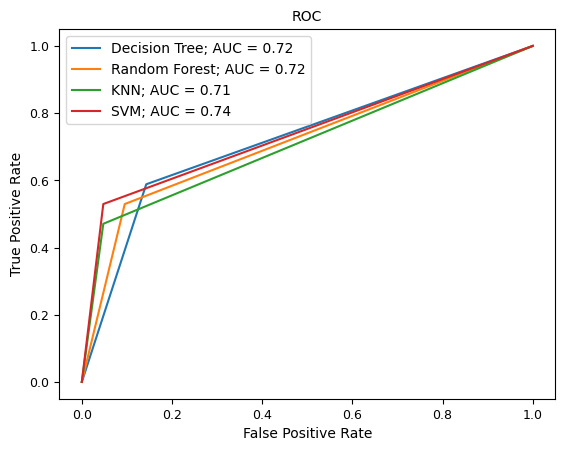

In [130]:
plt.plot(dt_frp, dt_tpr, label=f"Decision Tree; AUC = {dt_auc:.2f}")
plt.plot(rf_frp, rf_tpr, label=f"Random Forest; AUC = {rf_auc:.2f}")
plt.plot(knn_frp, knn_tpr, label=f"KNN; AUC = {knn_auc:.2f}")
plt.plot(svm_frp, svm_tpr, label=f"SVM; AUC = {svm_auc:.2f}")


plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")

In this case, the SVM model is the option to go with!